<a href="https://colab.research.google.com/github/ayrna/ap2122/blob/main/redes_recurrentes/time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Profundo - Práctica 2: Redes Neuronales Recurrentes

A continuación se va a realizar el ejercicio propuesto en clase haciendo uso de redes neuronales recurrentes.

Utilizaremos una serie temporal sobre producción industrial de los servicios públicos de electricidad y gas en Estados Unidos, de los años 1939 a 2019, con frecuencia de muestreo mensual.

Se repetirá el entrenamiento de la red cambiando los parámetros del modelo. Se modificará el tamaño de batch (que se estableció a 500) y el número de neuronas de la LSTM o de la GRU (que se estableció a 32). También se probará a incrementar el número de épocas.

En este cuaderno, vamos a usar keras para construir una red LSTM que resuelva un problema de predicción en series temporales.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

El siguiente paso es cargar nuestro conjunto de datos de entrenamiento como un `DataFrame` de Pandas. A continuación, podemos extraer la matriz `numpy` del `DataFrame` y convertir los valores enteros en valores de punto flotante, que son más adecuados para el modelado con una red neuronal.

               ipg
date              
1939-01-01  3.3842
1939-02-01  3.4100
1939-03-01  3.4875
1939-04-01  3.5133
1939-05-01  3.5133


<ipython-input-9-aa6c29b708c1>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Month = pd.to_datetime(df.date)


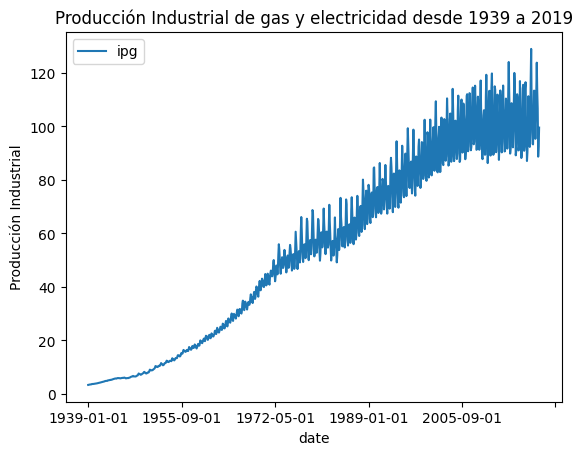

In [ ]:
# Cargar el conjunto de datos usando pandas
df = pd.read_csv("data/produccion-energia.csv")

# Rename columns - DATE,IPG2211A2N
df.columns = ['date', 'ipg']

# Dar el formato correcto a la fecha y usarlo como índice
df.Month = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

# Mostrar los primeros datos
print(df.head())

# Usar matplotlib para mostrar la serie
df.plot()
plt.title("Producción Industrial de gas y electricidad desde 1939 a 2019")
plt.ylabel("Producción Industrial")
plt.show()

# Fijar la semilla para reproducibilidad
numpy.random.seed(7)

Las redes LSTM pueden ser sensibles a la escala de los datos de entrada. Puede ser buena idea rescalar los datos en el rango [0,1]. Para ello, vamos a usar `MinMaxScaler`.

In [ ]:
ipg = df['ipg']
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ipg.values.reshape(-1,1))

Después de modelar nuestros datos y estimar su rendimiento en el conjunto de datos de entrenamiento, tenemos que hacernos una idea de su comportamiento con datos no vistos. Con los datos de series temporales, la secuencia de valores es importante. Un método sencillo que podemos utilizar es dividir el conjunto de datos ordenados en conjuntos de datos de entrenamiento y otro de test. El código siguiente calcula el índice del punto de división y separa los datos en conjuntos de datos de entrenamiento con el 67% de las observaciones que podemos utilizar para entrenar nuestro modelo, dejando el 33% restante para probar el modelo.

In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Ahora vamos a definir una función que va a generar los datos para el entrenamiento de la LSTM.

La función toma dos argumentos: el conjunto de datos, que es un array de NumPy que queremos convertir en un conjunto de datos, y el look_back, que es el número de pasos de tiempo anteriores que se utilizarán como variables de entrada para predecir el siguiente período de tiempo - en este caso, por defecto, 1.

Este valor predeterminado creará un conjunto de datos donde X es el número de pasajeros en un momento dado (t) e Y es el número de pasajeros en el siguiente momento (t + 1).

De esta forma, estamos siguiendo la estrategia `one-to-one`.

In [ ]:
# Convertir un array en un conjunto de datos
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

Ahora podemos utilizar esta función para preparar los conjuntos de datos de entrenamiento y test para el modelado.

In [ ]:
look_back = 1
# Preparar el conjunto de train
trainX, trainY = create_dataset(train, look_back)

# Preparar el conjunto de test
testX, testY = create_dataset(test, look_back)

Podríamos haber hecho esto de forma más fácil usando el método `shift()`.

La red LSTM espera que los datos de entrada (X) tenga una estructura 3D de la siguiente forma: `[samples, time steps, features]`. Los `samples` son el número de instantes (filas) que vamos a usar para entrenar. En `time_steps` tendremos tantos como entradas reciba a la vez la red por cada instante de tiempo. En `features` vamos a tener las distintas variables que pudiera considerar la red.

En nuestro caso, el array es de `[samples, features]`, nos falta una dimensión. Además, `time_steps=1` (`one-to-one`) y `features=1` (univariante). Pero tenemos que convertir la X a 3D. Lo haremos usando `reshape()`.

In [ ]:
# Reshape para tener [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

Ahora ya podemos diseñar nuestra red LSTM para el problema de predicción.

Vamos a tener una capa visible con 1 entrada, una capa oculta con 4 bloques LSTM y una capa de salida que realizará una predicción. La función de activación sigmoide se va a usar para los bloques LSTM.

La opción `stateful=True` es importante. Hace que la memoria de la LSTM no se resetee después de cada batch. Obliga a especificar el `batch_size`, ya que así sabremos la memoria máxima.

In [ ]:
# Tamaño de batch
batch_size=1

# Crear un modelo secuencial
model = Sequential()

# Crear una capa LSTM
model.add(LSTM(10, batch_input_shape=(batch_size, look_back, 1), stateful=True))

# Crear una capa densa
model.add(Dense(1))

Ahora compilamos y entrenamos durante 100 épocas con tamaño de batch 1.

Para forzar a que el estado se resetee una vez hayamos pasado por toda la serie temporal, vamos a incluir un bucle para el número de épocas, en lugar de usar la forma habitual.

In [ ]:
# Compilar el modelo
model.compile(optimizer="adam", loss='mean_squared_error')

# Entrenamiento habitual (no resetearía el estado)
# model.fit(trainX, trainY, epochs=30, batch_size=1)

# Entrenar el modelo con reseteo explícito
for i in range(100):
  print('Época %d'%(i))
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()

Época 0
645/645 - 2s - loss: 8.0169e-04 - 2s/epoch - 4ms/step
Época 1
645/645 - 1s - loss: 0.0010 - 721ms/epoch - 1ms/step
Época 2
645/645 - 1s - loss: 8.6562e-04 - 702ms/epoch - 1ms/step
Época 3
645/645 - 1s - loss: 7.9476e-04 - 719ms/epoch - 1ms/step
Época 4
645/645 - 1s - loss: 7.5150e-04 - 726ms/epoch - 1ms/step
Época 5
645/645 - 1s - loss: 7.2135e-04 - 711ms/epoch - 1ms/step
Época 6
645/645 - 1s - loss: 6.9667e-04 - 681ms/epoch - 1ms/step
Época 7
645/645 - 1s - loss: 6.7385e-04 - 1s/epoch - 2ms/step
Época 8
645/645 - 1s - loss: 6.5117e-04 - 755ms/epoch - 1ms/step
Época 9
645/645 - 1s - loss: 6.2784e-04 - 799ms/epoch - 1ms/step
Época 10
645/645 - 1s - loss: 6.0349e-04 - 705ms/epoch - 1ms/step
Época 11
645/645 - 1s - loss: 5.7795e-04 - 699ms/epoch - 1ms/step
Época 12
645/645 - 1s - loss: 5.5118e-04 - 708ms/epoch - 1ms/step
Época 13
645/645 - 1s - loss: 5.2326e-04 - 688ms/epoch - 1ms/step
Época 14
645/645 - 1s - loss: 4.9448e-04 - 701ms/epoch - 1ms/step
Época 15
645/645 - 1s - loss: 

Una vez ajustado el modelo, podemos estimar su rendimiento en los conjuntos de datos de entrenamiento y de test. Esto nos dará un punto de comparación para los nuevos modelos.

Hay que tener en cuenta que invertimos las predicciones antes de calcular las puntuaciones de error para asegurarnos de que el rendimiento se presenta en las mismas unidades que los datos originales (miles de pasajeros al mes).

In [ ]:
# Realizar las predicciones
trainPredict = model.predict(trainX,batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# Deshacer la normalización
trainPredict = scaler.inverse_transform(trainPredict)
trainYOriginal = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYOriginal = scaler.inverse_transform([testY])
# Calcular los error
trainScore = math.sqrt(mean_squared_error(trainYOriginal[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYOriginal[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

317/317 [==============================] - 0s 1ms/step
Train Score: 56.80 RMSE
Test Score: 66.35 RMSE


Por último, podemos generar predicciones utilizando el modelo para el conjunto de datos de entrenamiento y de test para obtener una indicación visual de la habilidad del modelo.

Debido a la forma en que se preparó el conjunto de datos, debemos desplazar las predicciones para que se alineen en el eje x con el conjunto de datos original. Una vez preparados, los datos se representan, mostrando el conjunto de datos original en azul, las predicciones del conjunto de datos de entrenamiento en verde y las predicciones del conjunto de datos de prueba no visto en rojo.

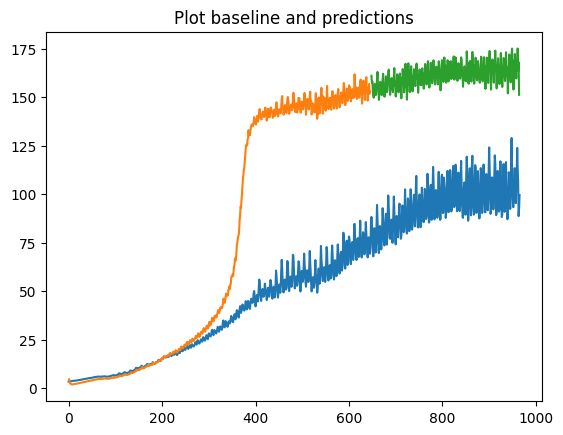

In [ ]:
# Hacer un shift de las predicciones de entrenamiento para el plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Hacer un shift de las predicciones de test para el plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Representar las predicciones
plt.title("Plot baseline and predictions")

plt.legend(['Dataset', 'Train', 'Test', 'Predicciones Train', 'Predicciones Test'])

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Como podemos ver, la red ha hecho un buen trabajo, aunque las predicciones empiezan a desviarse al final.

---



# Experimentación

Para realizar una experimentación y poder compararlo con el modelo anterior se deben cambiar los parámetros uno a uno para así poder saber si el cambio ha realizado una mejora o un empeoramiento en el modelo. Si se realizan varios cambios en los hiperparámetros es difícil saber cuál ha sido el que ha podido producir más o menos mejora o empeoramiento.

Por eso se realizarán 3 experimentos:
- Cambio de batch
- Cambio de número de neuronas
- Cambio de epochs

## Función

Para facilitar la experimentación se va a crear una función cuyos inputs son los parámetros con los que se va a experimentar, en el enunciado del ejercicio venían descritos unos valores que no se corresponden con los de este notebook, por lo que primero se va a ejecutar la función con los valores predeterminados según el enunciado y a partir de ahí se modificarán.

Sin embargo, se dice que el batch size establecido es 500 sin embargo este valor da un error al provocar una diferencia entre los shapes que se introducen al modelo. También puede dar error si se introdce un número demasiado grande y no puede ser alojado en memoria, tras realizar unas pruebas el número que no ha dado error ha sido 4.

Entre otros errores se encuentra:
ValueError: Found input variables with inconsistent numbers of samples: [645, 648]
Dado porque X e Y tienen diferentes tamaños, al comprobarlo:

In [ ]:
print(trainX.shape)
print(trainY.shape)

Tras realizar varios experimentos, los batches están dando el problema de que no terminar el conjunto de datos de entrenamiento, por lo que si en entrenamiento hay X muestras, el número de batch debe ser uno que sea módulo.

Es decir trainX.shape % X == 0

Con 4 da error, y con 2 también. El número con el que funcionará siempre será 1, por lo que este será el número que se establecerá como predeterminado.

In [ ]:
def experiment_recurrent_neural_network(batch=1, LSTM_neurons = 32, n_epochs = 100):
  # Tamaño de batch
  batch_size=batch

  # Crear un modelo secuencial
  model = Sequential()

  # Crear una capa LSTM
  model.add(LSTM(LSTM_neurons, batch_input_shape=(batch_size, look_back, 1), stateful=True))

  # Crear una capa densa
  model.add(Dense(1))

  # Compilar el modelo
  model.compile(optimizer="adam", loss='mean_squared_error')

  # Entrenamiento habitual (no resetearía el estado)
  # model.fit(trainX, trainY, epochs=30, batch_size=1)

  # Entrenar el modelo con reseteo explícito
  for i in range(n_epochs):
    print('Época %d'%(i))
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

  # Realizar las predicciones
  trainPredict = model.predict(trainX,batch_size=batch_size)
  testPredict = model.predict(testX,batch_size=batch_size)
  # Deshacer la normalización
  trainPredict = scaler.inverse_transform(trainPredict)
  trainYOriginal = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testYOriginal = scaler.inverse_transform([testY])
  # Calcular los error
  trainScore = math.sqrt(mean_squared_error(trainYOriginal[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testYOriginal[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))


  # Hacer un shift de las predicciones de entrenamiento para el plot
  trainPredictPlot = numpy.empty_like(dataset)
  trainPredictPlot[:, :] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # Hacer un shift de las predicciones de test para el plot
  testPredictPlot = numpy.empty_like(dataset)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

  # Representar las predicciones
  plt.title("Plot baseline and predictions")
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()

Época 0
645/645 - 2s - loss: 9.6248e-04 - 2s/epoch - 3ms/step
Época 1
645/645 - 1s - loss: 9.7975e-04 - 774ms/epoch - 1ms/step
Época 2
645/645 - 1s - loss: 8.5600e-04 - 741ms/epoch - 1ms/step
Época 3
645/645 - 1s - loss: 7.9215e-04 - 762ms/epoch - 1ms/step
Época 4
645/645 - 1s - loss: 7.1854e-04 - 758ms/epoch - 1ms/step
Época 5
645/645 - 1s - loss: 6.3273e-04 - 744ms/epoch - 1ms/step
Época 6
645/645 - 1s - loss: 5.6649e-04 - 735ms/epoch - 1ms/step
Época 7
645/645 - 1s - loss: 5.1866e-04 - 861ms/epoch - 1ms/step
Época 8
645/645 - 1s - loss: 5.0722e-04 - 992ms/epoch - 2ms/step
Época 9
645/645 - 1s - loss: 4.2995e-04 - 750ms/epoch - 1ms/step
Época 10
645/645 - 1s - loss: 3.7490e-04 - 771ms/epoch - 1ms/step
Época 11
645/645 - 1s - loss: 3.3817e-04 - 735ms/epoch - 1ms/step
Época 12
645/645 - 1s - loss: 3.1777e-04 - 738ms/epoch - 1ms/step
Época 13
645/645 - 1s - loss: 3.0645e-04 - 746ms/epoch - 1ms/step
Época 14
645/645 - 1s - loss: 2.9823e-04 - 745ms/epoch - 1ms/step
Época 15
645/645 - 1s -

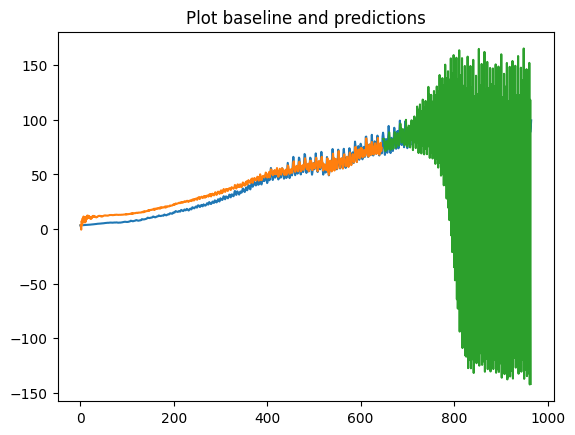

In [ ]:
experiment_recurrent_neural_network()

## Cambio de número de batch

El código a continuación da error, para demostrar que tal y como se han dado los códigos no se puede aumentar en este caso el batchsize

In [ ]:
experiment_recurrent_neural_network(batch=128)

Época 0


InvalidArgumentError: Graph execution error:

Detected at node while/add defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-59-95dfbdeb2c98>", line 1, in <cell line: 1>

  File "<ipython-input-56-6d5e8981f5e1>", line 23, in experiment_recurrent_neural_network

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/base_rnn.py", line 556, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 749, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 1339, in lstm_with_backend_selection

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 981, in standard_lstm

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5168, in rnn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5147, in _step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 968, in step

Incompatible shapes: [5,128] vs. [128,128]
	 [[{{node while/add}}]]
	 [[sequential_17/lstm_17/PartitionedCall]] [Op:__inference_train_function_774320]

## Cambiar número de LSTM neurons

Vamos a cambiar a un número mayor, a 64

Época 0
645/645 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Época 1
645/645 - 1s - loss: 0.0012 - 1s/epoch - 2ms/step
Época 2
645/645 - 1s - loss: 0.0011 - 845ms/epoch - 1ms/step
Época 3
645/645 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Época 4
645/645 - 1s - loss: 0.0012 - 763ms/epoch - 1ms/step
Época 5
645/645 - 1s - loss: 8.8346e-04 - 755ms/epoch - 1ms/step
Época 6
645/645 - 1s - loss: 7.6500e-04 - 994ms/epoch - 2ms/step
Época 7
645/645 - 1s - loss: 6.4950e-04 - 757ms/epoch - 1ms/step
Época 8
645/645 - 1s - loss: 5.6322e-04 - 747ms/epoch - 1ms/step
Época 9
645/645 - 1s - loss: 4.9165e-04 - 770ms/epoch - 1ms/step
Época 10
645/645 - 1s - loss: 4.3633e-04 - 746ms/epoch - 1ms/step
Época 11
645/645 - 1s - loss: 3.9909e-04 - 765ms/epoch - 1ms/step
Época 12
645/645 - 1s - loss: 3.7398e-04 - 760ms/epoch - 1ms/step
Época 13
645/645 - 1s - loss: 3.5706e-04 - 783ms/epoch - 1ms/step
Época 14
645/645 - 1s - loss: 3.4728e-04 - 768ms/epoch - 1ms/step
Época 15
645/645 - 1s - loss: 3.4312e-04 - 762ms/

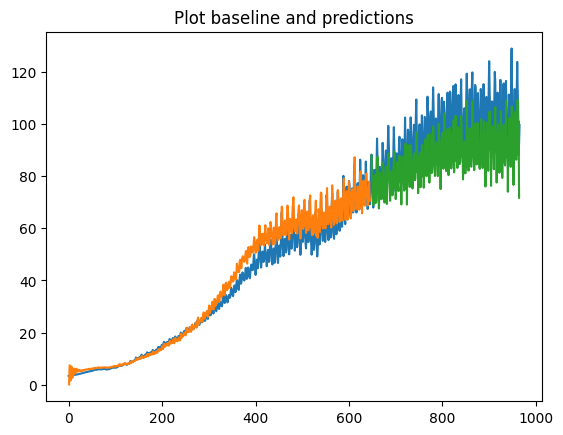

In [ ]:
experiment_recurrent_neural_network(batch=1, LSTM_neurons = 64)

En este caso train score ha disminuído un poco, pero en el caso de test ha disminuído mucho.

## Cambio de epochs

Ahora vamos a aumentar el número de épocas a 300

Época 0
645/645 - 41s - loss: 9.3493e-04 - 41s/epoch - 64ms/step
Época 1
645/645 - 1s - loss: 0.0011 - 780ms/epoch - 1ms/step
Época 2
645/645 - 1s - loss: 9.7792e-04 - 816ms/epoch - 1ms/step
Época 3
645/645 - 1s - loss: 8.8379e-04 - 799ms/epoch - 1ms/step
Época 4
645/645 - 1s - loss: 7.7912e-04 - 767ms/epoch - 1ms/step
Época 5
645/645 - 1s - loss: 6.7340e-04 - 807ms/epoch - 1ms/step
Época 6
645/645 - 1s - loss: 5.3210e-04 - 810ms/epoch - 1ms/step
Época 7
645/645 - 1s - loss: 4.0266e-04 - 790ms/epoch - 1ms/step
Época 8
645/645 - 1s - loss: 2.9941e-04 - 790ms/epoch - 1ms/step
Época 9
645/645 - 1s - loss: 2.4732e-04 - 909ms/epoch - 1ms/step
Época 10
645/645 - 1s - loss: 2.3289e-04 - 748ms/epoch - 1ms/step
Época 11
645/645 - 1s - loss: 2.3299e-04 - 804ms/epoch - 1ms/step
Época 12
645/645 - 1s - loss: 2.3678e-04 - 775ms/epoch - 1ms/step
Época 13
645/645 - 1s - loss: 2.4850e-04 - 769ms/epoch - 1ms/step
Época 14
645/645 - 1s - loss: 2.6355e-04 - 789ms/epoch - 1ms/step
Época 15
645/645 - 1s - 

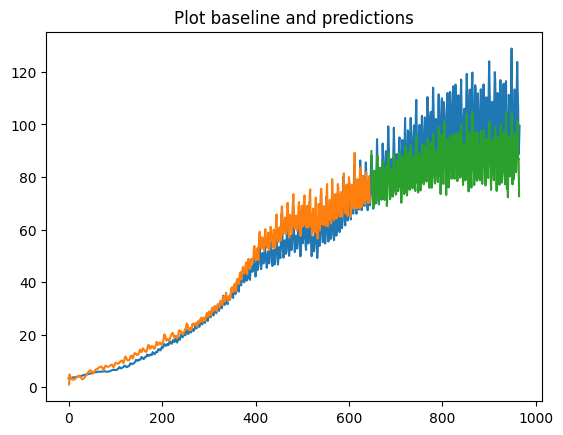

In [ ]:
experiment_recurrent_neural_network(n_epochs = 300)

En este caso, además de tardar más tiempo al tener más épocas. Además, train score y test score también han disminuído. Aunque son mayores que los del experimento de mayor número de neuronas.



## Referencias

Este material se ha basado en la entrada ["Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras"](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) de Machine Learning Mastery. Es muy recomendable consultar la entrada completa.